In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing
import re
import pickle
from collections import Counter

sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df=pd.read_csv("/kaggle/input/zomato-bangalore-restaurants/zomato.csv")
df.head(3)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari


In [3]:
#string col specific avg ratings
def col_specific_rate(unique_list,dataset,col_name,new_data_col_names):
    unique_col_name=[]
    unique_col_avg_rate=[]
    for u in unique_list:
        unique_col_name.append(u)
        rate_dict=Counter(dataset[dataset[col_name].str.contains(u)]['ratings'].values)
        rate_total=0
        rate_total_count=0
        for k, v in rate_dict.items():
            rate_total=rate_total+(k*v)
            rate_total_count=rate_total_count+v
        if rate_total_count!=0:
            unique_col_avg_rate.append(round(rate_total/rate_total_count))
        else:
            unique_col_avg_rate.append(0)
    new_dataset={new_data_col_names[0]:unique_col_name,new_data_col_names[1]:unique_col_avg_rate}
    return pd.DataFrame(new_dataset)

In [4]:
#string separator to show unique values
def to_split_separator(dataToSplit):
    #return dataToSplit.values
    #return pd.Series([x.strip().replace(' ','') for _list in dataToSplit for x in str(_list).split(',')])
    return pd.Series([x.strip() for _list in dataToSplit for x in str(_list).split(',')])

In [5]:
#plot pie_chart

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

def plot_pie_chart(plt,data,types_label,palette):
    plt.title("pie chart")
    plt.pie(data, labels = types_label, colors = palette, autopct=autopct_format(data))

In [6]:
df.shape

(51717, 17)

In [7]:
#description columns
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [8]:
#infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [9]:
#check unique ratings
df.rate.unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [10]:
#check nan values
df.isna().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [11]:
df[df.votes==0].rate.unique()

array(['NEW', nan, '3.7/5', '-', '4.0/5', '3.6 /5', '3.7 /5', '4.3 /5',
       '3.9 /5', '3.8 /5', '3.4 /5', '3.3 /5', '4.1 /5'], dtype=object)

In [12]:
#checking the results which have value New in rate
df[df.rate=='NEW'].votes.unique()

array([0], dtype=int64)

In [13]:
df[df.rate=='-'].votes.unique()

array([0], dtype=int64)

In [14]:
#replacing the rate na,new,- values with 0
df.rate.fillna(0, inplace=True)

In [15]:
 df['rate']=np.where(df['rate']=='NEW',0,df['rate'])

In [16]:
 df['rate']=np.where(df['rate']=='-',0,df['rate'])

In [17]:
#checking the rate unique values again
df.rate.unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 0, '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5', '4.5/5',
       '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5', '3.4 /5',
       '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5', '4.1 /5',
       '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5', '3.5 /5',
       '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5', '4.3 /5',
       '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5', '4.9 /5',
       '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5', '2.1 /5',
       '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [18]:
#modifying the rating values
df['ratings']=df['rate'].apply(lambda x: 0 if x ==0 else x.split('/')[0])

In [19]:
df['ratings'] = df['ratings'].str.replace(' ','').astype(np.float64)

In [20]:
df.ratings.fillna(0,inplace=True)

In [21]:
df.ratings.unique()

array([4.1, 3.8, 3.7, 3.6, 4.6, 4. , 4.2, 3.9, 3.1, 3. , 3.2, 3.3, 2.8,
       4.4, 4.3, 0. , 2.9, 3.5, 2.6, 3.4, 4.5, 2.5, 2.7, 4.7, 2.4, 2.2,
       2.3, 4.8, 4.9, 2.1, 2. , 1.8])

In [22]:
df=df.drop(['rate'],axis=1)
df.head()

,url,address,name,online_order,book_table,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),ratings
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,4.1
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,4.1
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,3.8
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,3.7
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,3.8


In [23]:
df['approx_cost(for two people)']=df['approx_cost(for two people)'].fillna(0)

In [24]:
df = df.astype({'approx_cost(for two people)':str})
df['approx_cost(for two people)']=[x.replace(',', '') for x in df['approx_cost(for two people)'].values]

In [25]:
df = df.astype({'approx_cost(for two people)':int})

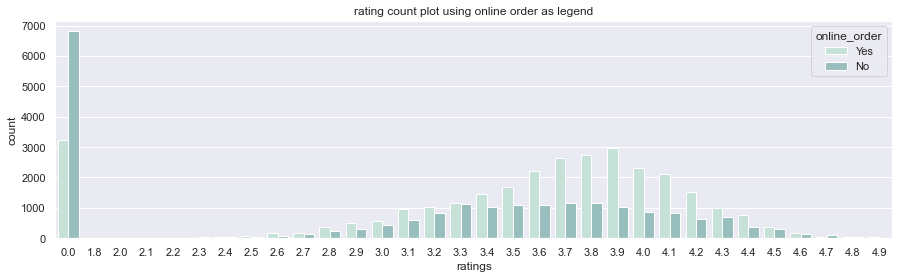

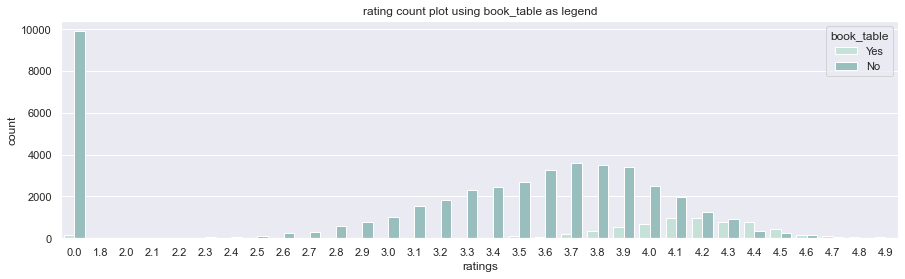

In [26]:
# palette=sns.color_palette("cubehelix")
# sns.set_palette(palette)

palette=sns.cubehelix_palette(start=.5, rot=-.5)
sns.set_palette(palette)

#rating counts using online order as legend
fig = plt.figure(figsize=[15,4])
plt.title("rating count plot using online order as legend")
sns.countplot(x="ratings", hue="online_order", data=df)
plt.show()


#rating counts using book_table as legend
fig = plt.figure(figsize=[15,4])
plt.title("rating count plot using book_table as legend")
sns.countplot(x="ratings", hue="book_table", data=df)
plt.show()

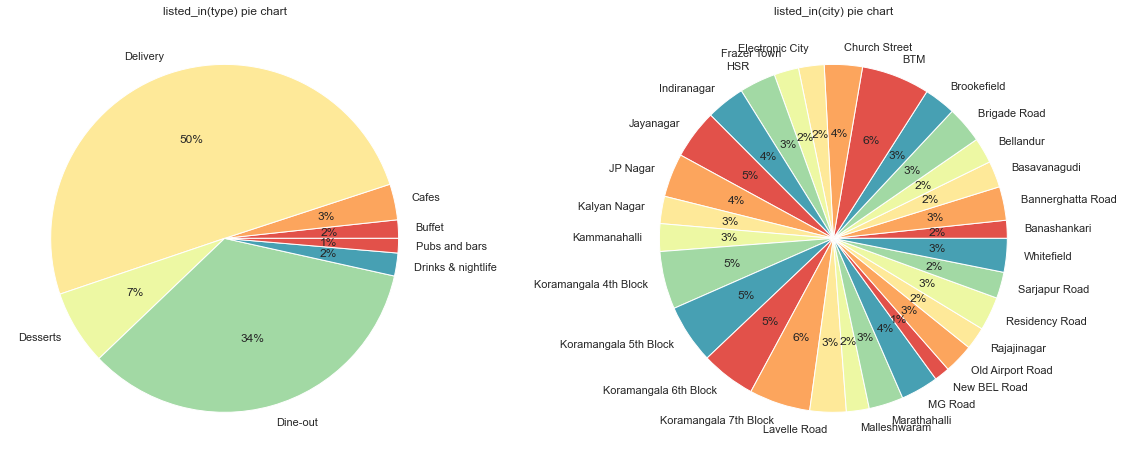

In [27]:
#pie chart using listed_in_type
listed_in_type_values_dict=Counter(df['listed_in(type)'].values)
types_label=[]
types_counts=[]
for k,v in listed_in_type_values_dict.items():
    types_label.append(k)
    types_counts.append(v)
    
palette=sns.color_palette("Spectral")

fig = plt.figure(figsize=[20,8])

plt.subplot(1,2,1)
plt.title("listed_in(type) pie chart")
plt.pie(types_counts, labels = types_label, colors = palette, autopct='%.0f%%')

#listed in city
listed_in_city_values_dict=Counter(df['listed_in(city)'].values)
cities_label=[]
cities_counts=[]
for k,v in listed_in_city_values_dict.items():
    cities_label.append(k)
    cities_counts.append(v)

plt.subplot(1,2,2)
plt.title("listed_in(city) pie chart")
plt.pie(cities_counts, labels = cities_label, colors = palette, autopct='%.0f%%')

plt.show()

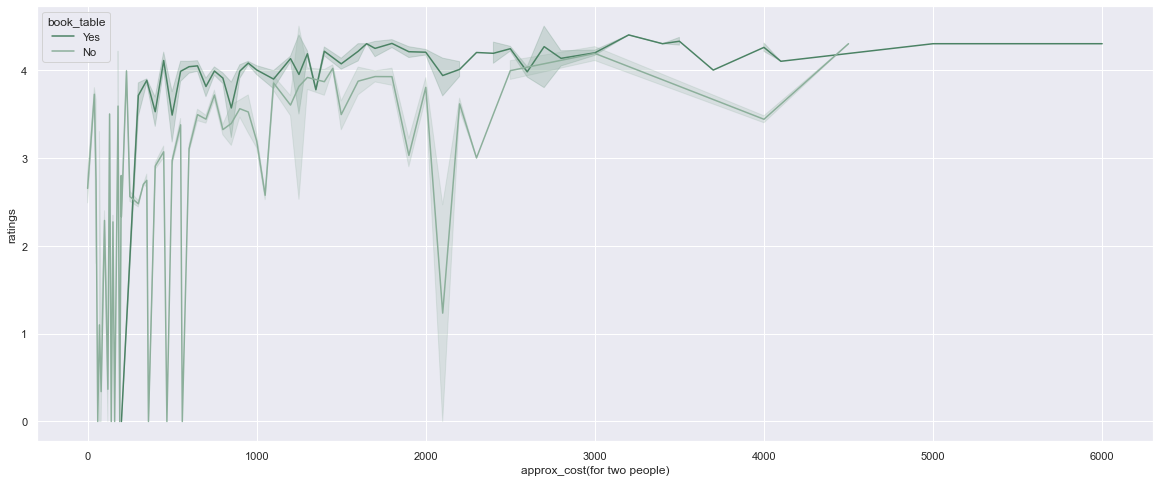

In [28]:
#plot for approx cost and ratings
palette=sns.diverging_palette(145, 300, s=60)
sns.set_palette(palette)
fig = plt.figure(figsize=[20,8])
ax=sns.lineplot(data=df, x="approx_cost(for two people)", y="ratings", hue="book_table")

plt.show()

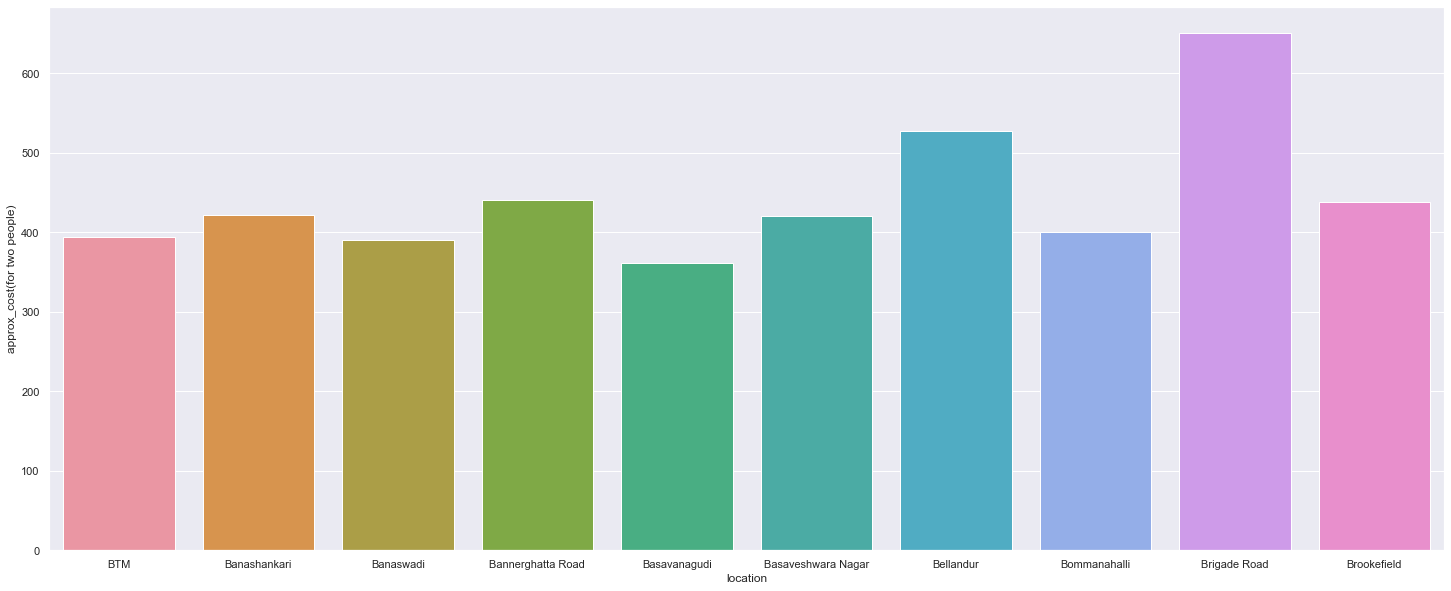

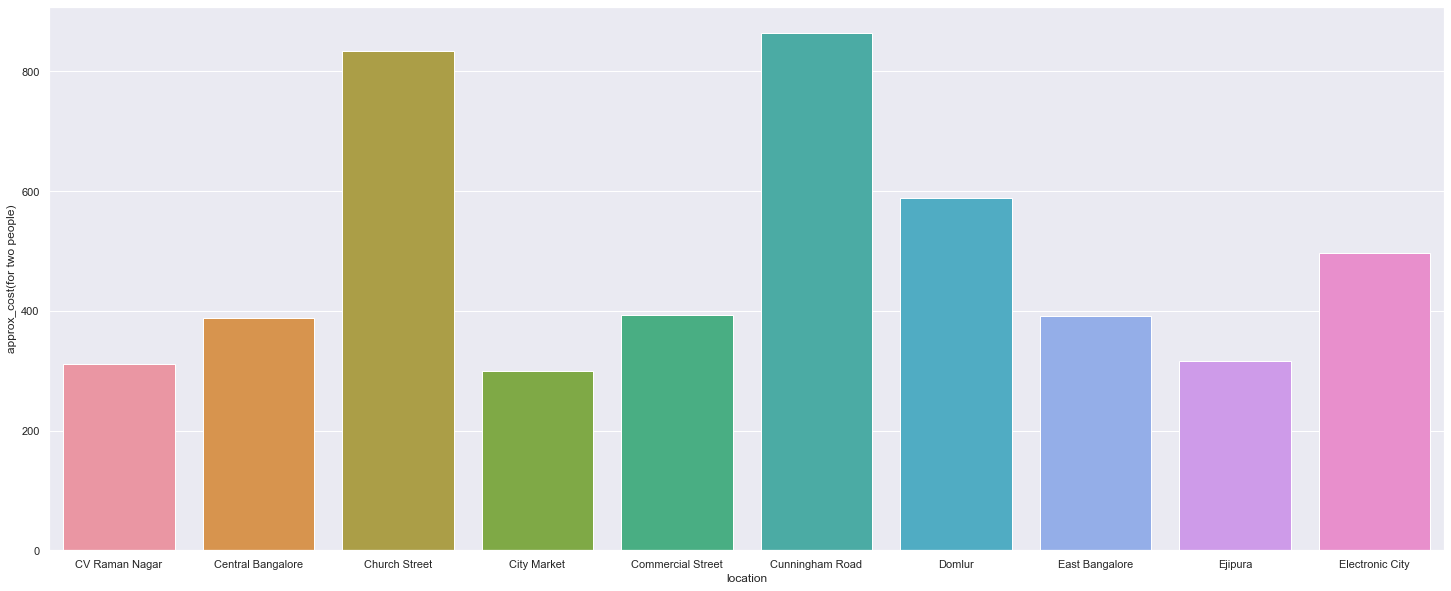

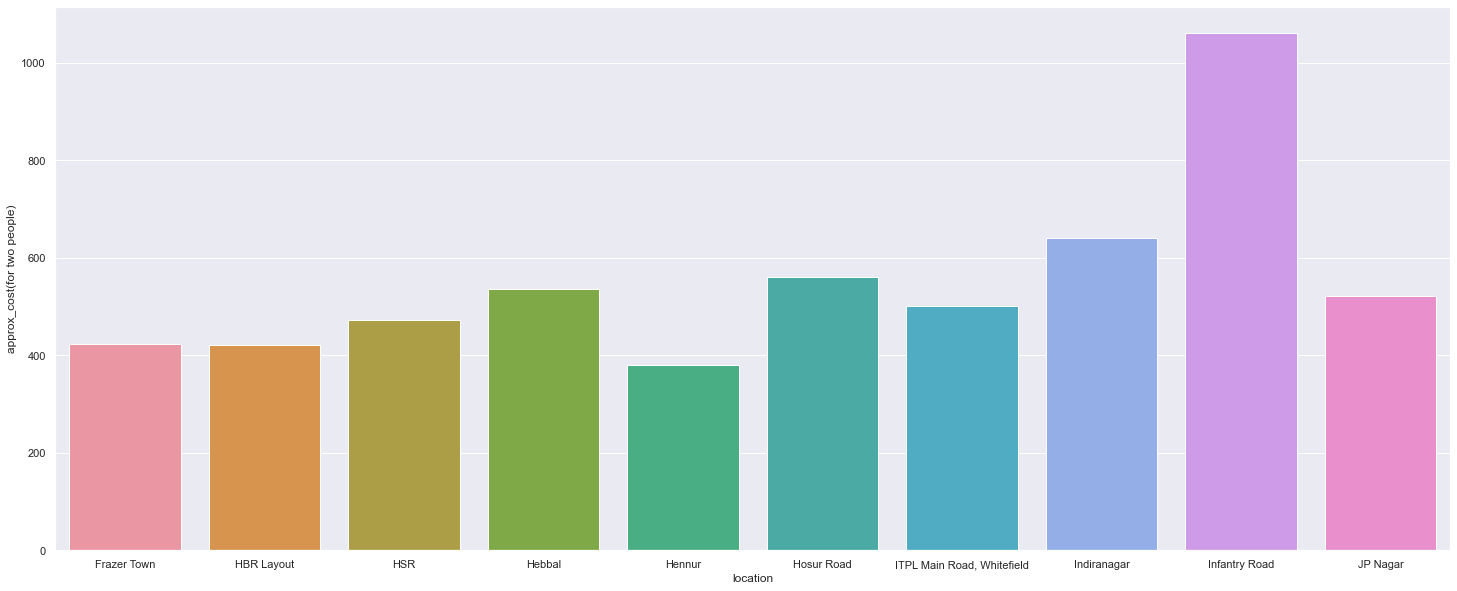

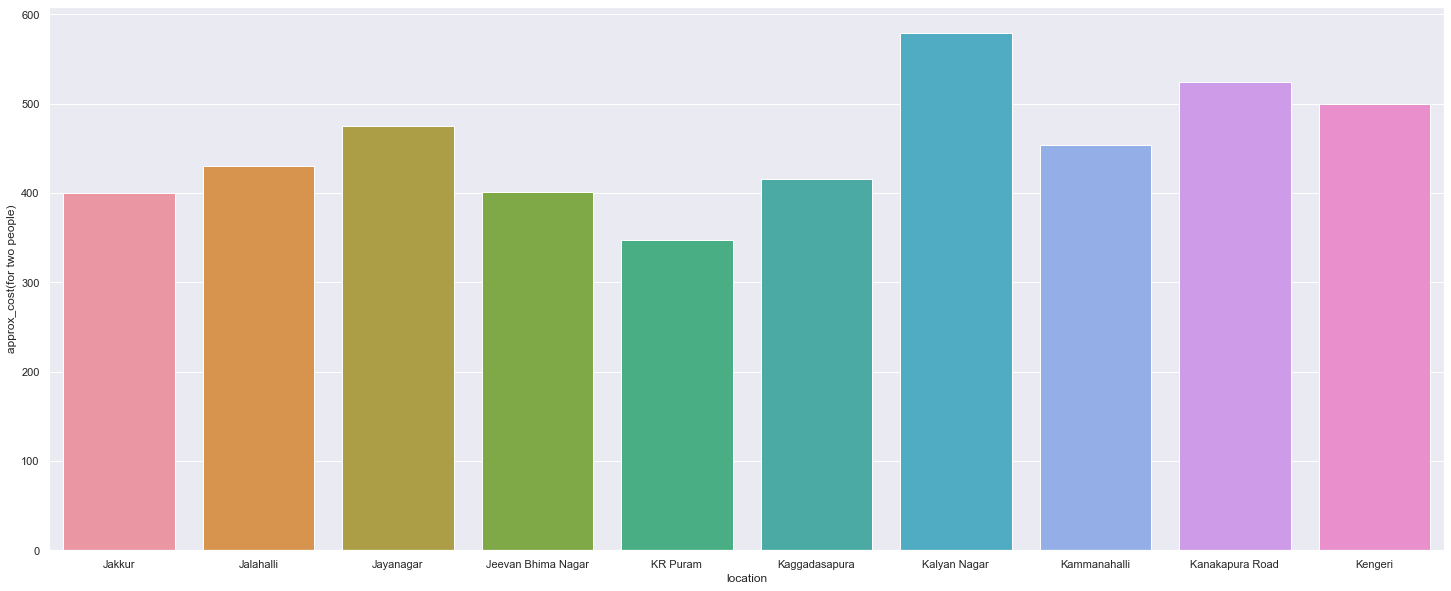

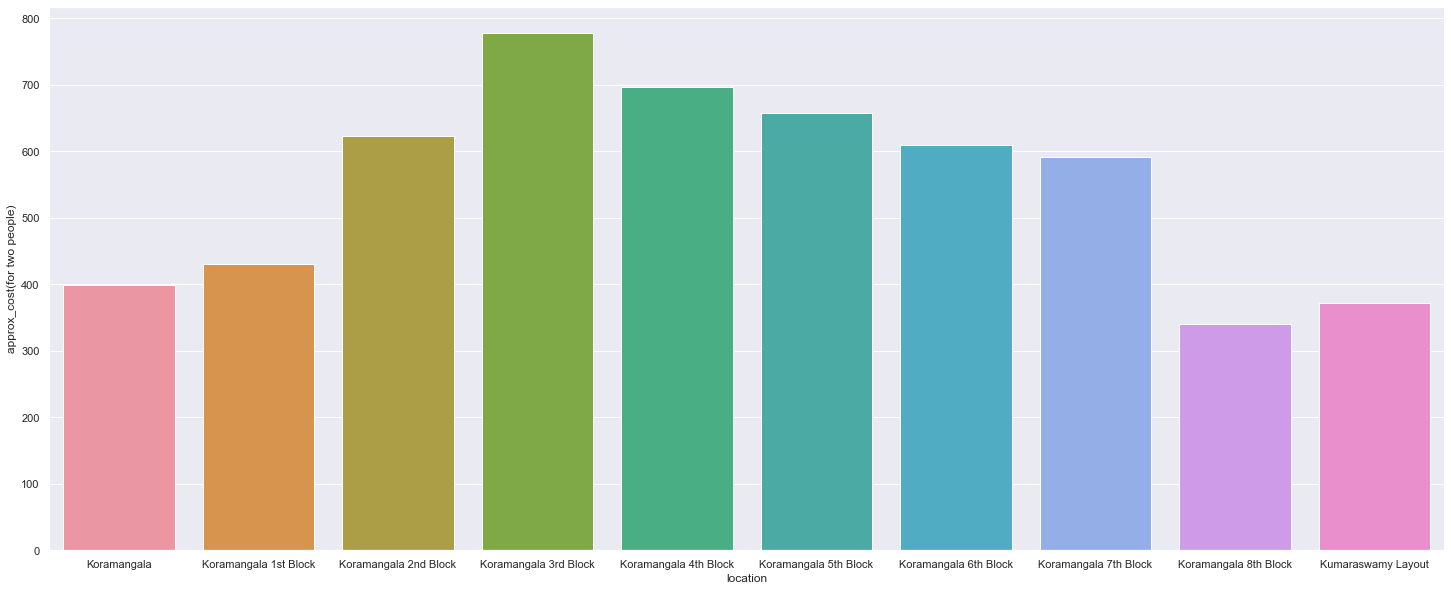

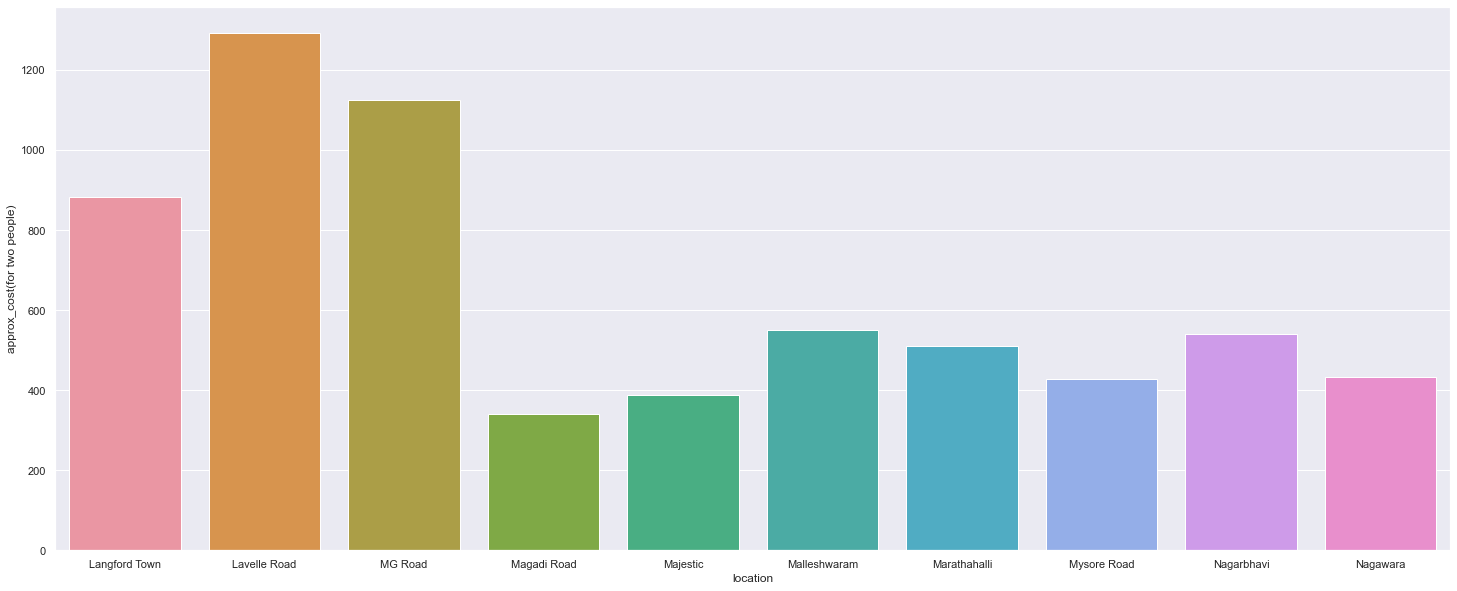

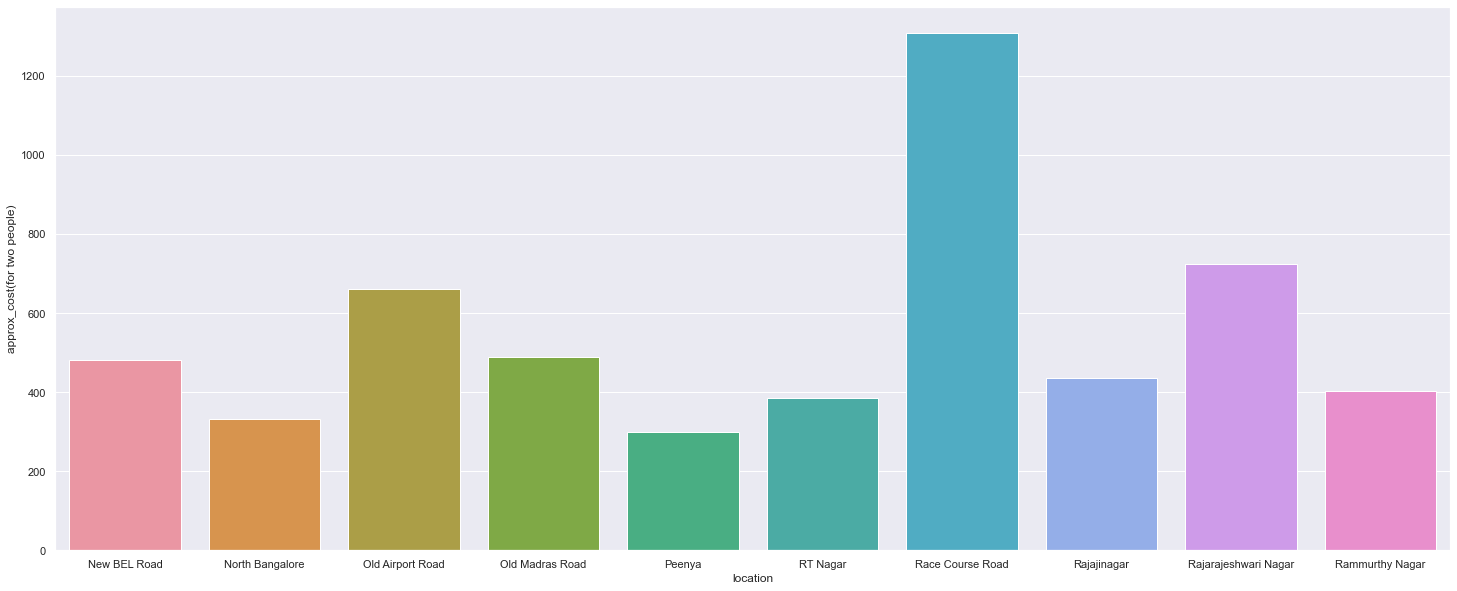

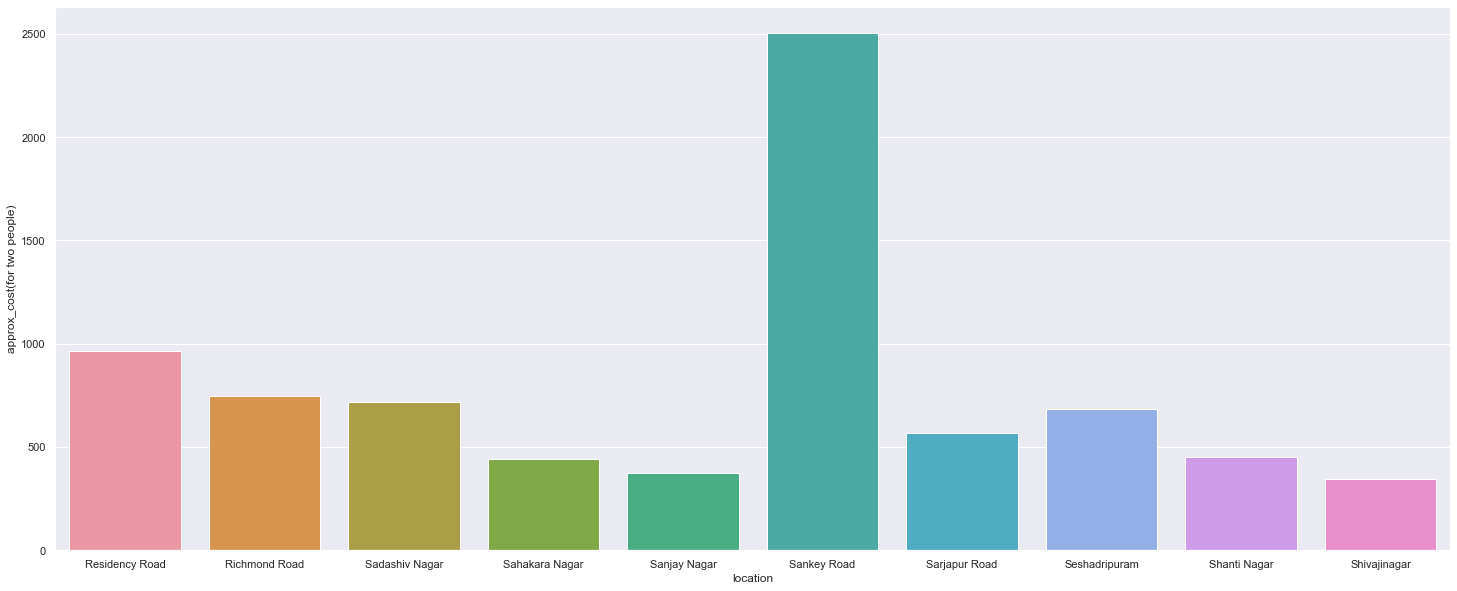

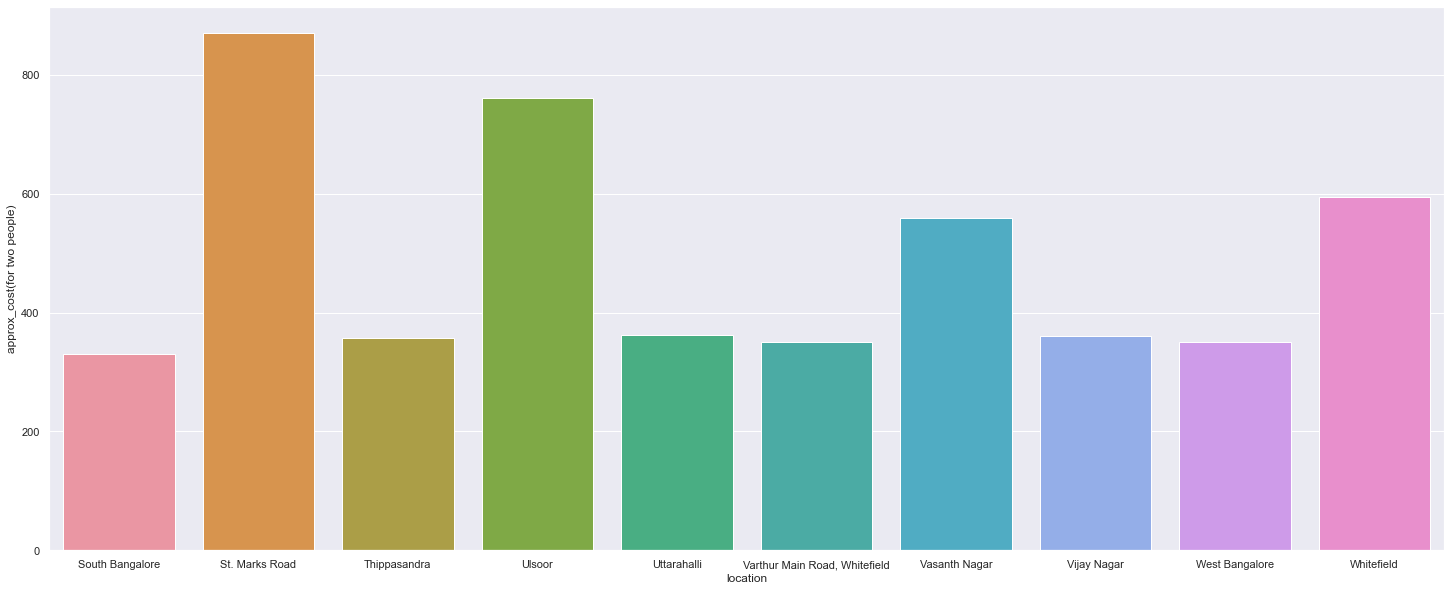

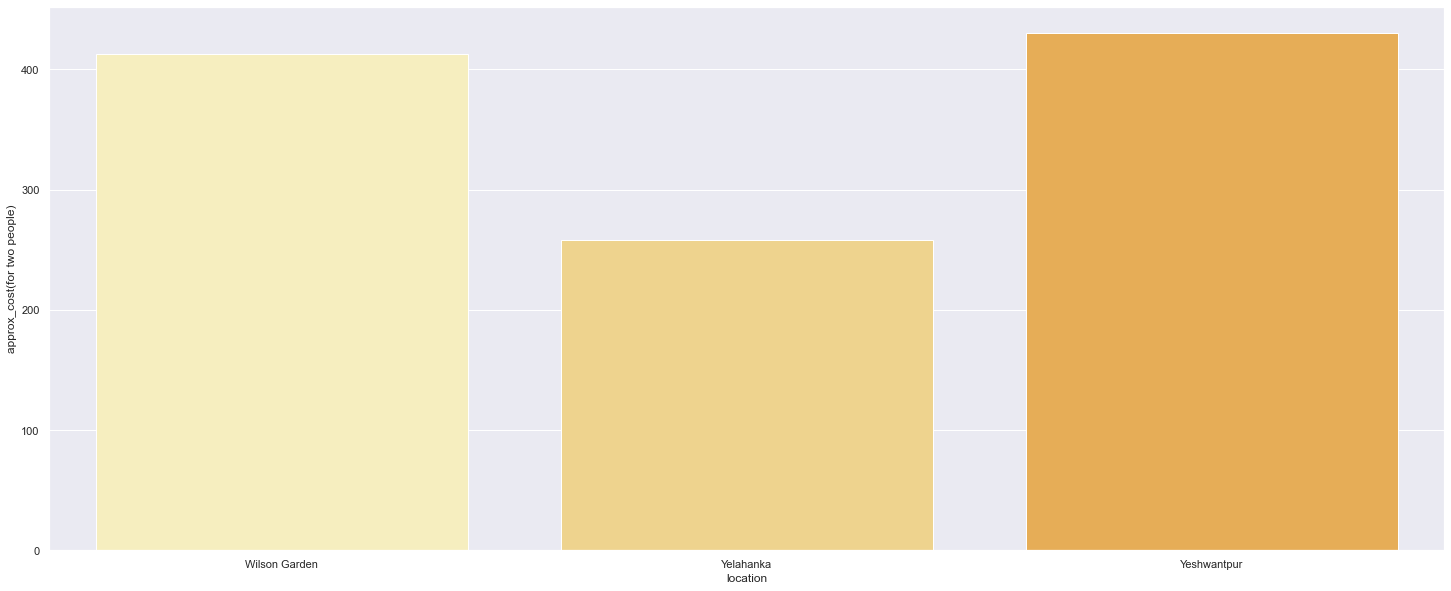

In [29]:
#location wise avg approx cost
location_avg_approx_cost=pd.DataFrame(df.groupby(['location']).mean().groupby('location')['approx_cost(for two people)'].mean().reset_index())

i=0
j=10
k=0
palette=sns.color_palette("YlOrBr")
sns.set_palette(palette)
while i<location_avg_approx_cost.shape[0]:
    
    fig = plt.figure(figsize=[25,10])
    sns.barplot(data=location_avg_approx_cost[i:j], x="location", y="approx_cost(for two people)")
    
    i=i+10
    j=j+10
    plt.show()


In [30]:
#collecting review counts
df["reviews_list"] = df["reviews_list"].apply(eval)

In [31]:
reviews_count=[len(r) for r in df['reviews_list']]
df["reviews_list"]=reviews_count
df.head()

,url,address,name,online_order,book_table,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),ratings
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,12,[],Buffet,Banashankari,4.1
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,14,[],Buffet,Banashankari,4.1
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,20,[],Buffet,Banashankari,3.8
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,35,[],Buffet,Banashankari,3.7
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,2,[],Buffet,Banashankari,3.8


In [32]:
rest_type_list=to_split_separator(df[~df['rest_type'].isna()]['rest_type'].values)
len(rest_type_list.unique())

25

In [33]:
df['rest_type'].isna().sum()

227

In [34]:
rest_type_unique_list=rest_type_list.unique()
rest_type_unique_list

array(['Casual Dining', 'Cafe', 'Quick Bites', 'Delivery', 'Mess',
       'Dessert Parlor', 'Bakery', 'Pub', 'Takeaway', 'Fine Dining',
       'Beverage Shop', 'Sweet Shop', 'Bar', 'Confectionery', 'Kiosk',
       'Food Truck', 'Microbrewery', 'Lounge', 'Food Court', 'Dhaba',
       'Club', 'Irani Cafee', 'Bhojanalya', 'Pop Up', 'Meat Shop'],
      dtype=object)

In [35]:
#rndom fill na rest_type
random_rest_type=np.random.choice(rest_type_unique_list,227)
m = df['rest_type'].isna()
df.loc[m, 'rest_type']=random_rest_type

In [36]:
rest_type_unique_list

array(['Casual Dining', 'Cafe', 'Quick Bites', 'Delivery', 'Mess',
       'Dessert Parlor', 'Bakery', 'Pub', 'Takeaway', 'Fine Dining',
       'Beverage Shop', 'Sweet Shop', 'Bar', 'Confectionery', 'Kiosk',
       'Food Truck', 'Microbrewery', 'Lounge', 'Food Court', 'Dhaba',
       'Club', 'Irani Cafee', 'Bhojanalya', 'Pop Up', 'Meat Shop'],
      dtype=object)

In [37]:
dframe={}
for r in rest_type_unique_list:
    dframe[r]=[]
    for i in df['rest_type']:
        if i.strip()==r.strip():
            dframe[r].append(1)
        else:
            dframe[r].append(0)
    df[r]=dframe[r]

In [38]:
df=df.drop(['rest_type'],axis=1)

In [39]:
cuisines=to_split_separator(df['cuisines'].values).unique()
cuisines

array(['North Indian', 'Mughlai', 'Chinese', 'Thai', 'Cafe', 'Mexican',
       'Italian', 'South Indian', 'Rajasthani', 'Andhra', 'Pizza',
       'Continental', 'Momos', 'Beverages', 'Fast Food', 'American',
       'French', 'European', 'Bakery', 'Burger', 'Desserts', 'Biryani',
       'Street Food', 'Rolls', 'Ice Cream', 'Healthy Food', 'Salad',
       'Asian', 'Korean', 'Indonesian', 'Japanese', 'Goan', 'Seafood',
       'Kebab', 'Steak', 'Mithai', 'Iranian', 'Sandwich', 'Juices',
       'Mangalorean', 'Vietnamese', 'Hyderabadi', 'Bengali', 'Arabian',
       'BBQ', 'Tea', 'Afghani', 'Lebanese', 'Finger Food', 'Tibetan',
       'nan', 'Charcoal Chicken', 'Middle Eastern', 'Mediterranean',
       'Wraps', 'Kerala', 'Oriya', 'Bihari', 'Roast Chicken',
       'Maharashtrian', 'Bohri', 'African', 'Nepalese', 'Turkish',
       'Tamil', 'Tex-Mex', 'Belgian', 'Gujarati', 'South American',
       'Konkan', 'Drinks Only', 'Awadhi', 'Chettinad', 'Coffee', 'Indian',
       'Afghan', 'Modern Indi

In [40]:
df['cuisines'].isna().sum()

45

In [41]:
#rndom fill na cuisine
random_cuisine_type=np.random.choice(cuisines,45)
m = df['cuisines'].isna()
df.loc[m, 'cuisines']=random_cuisine_type

In [42]:
df['cuisines'].isna().sum()

0

In [43]:
cframe={}
for r in cuisines:
    cframe[r]=[]
    for i in df['cuisines']:
        if i.strip()==r.strip():
            cframe[r].append(1)
        else:
            cframe[r].append(0)
    df[r]=cframe[r]

In [44]:
df['cuisines'].value_counts()

North Indian                                                                              2914
North Indian, Chinese                                                                     2385
South Indian                                                                              1828
Biryani                                                                                    918
Bakery, Desserts                                                                           911
Fast Food                                                                                  803
Desserts                                                                                   767
Cafe                                                                                       757
South Indian, North Indian, Chinese                                                        726
Bakery                                                                                     651
Chinese                                           

In [45]:
df=df.drop(['cuisines'],axis=1)

In [46]:
df['location'].isna().sum()

21

In [47]:
location_list=to_split_separator(df['location'].values)
location=location_list.unique()
location_list.value_counts()

BTM                      5124
HSR                      2523
Koramangala 5th Block    2504
Whitefield               2374
JP Nagar                 2235
Indiranagar              2083
Jayanagar                1926
Marathahalli             1846
Bannerghatta Road        1630
Bellandur                1286
Electronic City          1258
Koramangala 1st Block    1238
Brigade Road             1218
Koramangala 7th Block    1181
Koramangala 6th Block    1156
Sarjapur Road            1065
Ulsoor                   1023
Koramangala 4th Block    1017
MG Road                   918
Banashankari              906
Kalyan Nagar              853
Richmond Road             812
Frazer Town               727
Malleshwaram              725
Basavanagudi              684
Residency Road            675
Banaswadi                 664
Brookefield               658
New BEL Road              649
Kammanahalli              648
Rajajinagar               591
Church Street             569
Lavelle Road              529
Shanti Nag

In [48]:
location

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Nagarbhavi', 'Bannerghatta Road', 'BTM', 'Kanakapura Road',
       'Bommanahalli', 'nan', 'CV Raman Nagar', 'Electronic City', 'HSR',
       'Marathahalli', 'Sarjapur Road', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Koramangala 8th Block', 'Richmond Road',
       'Koramangala 7th Block', 'Jalahalli', 'Koramangala 4th Block',
       'Bellandur', 'Whitefield', 'East Bangalore', 'Old Airport Road',
       'Indiranagar', 'Koramangala 1st Block', 'Frazer Town', 'RT Nagar',
       'MG Road', 'Brigade Road', 'Lavelle Road', 'Church Street',
       'Ulsoor', 'Residency Road', 'Shivajinagar', 'Infantry Road',
       'St. Marks Road', 'Cunningham Road', 'Race Course Road',
       'Commercial Street', 'Vasanth Nagar', 'HBR Layout', 'Domlur',
       'Ejipura', 'Jeeva

In [49]:
#rndom fill na location
random_location_type=np.random.choice(location,21)
m = df['location'].isna()
df.loc[m, 'location']=random_location_type

In [50]:
df['location'].isna().sum()

0

In [51]:
le = preprocessing.LabelEncoder()

In [52]:
#label encoding on location
le.fit(df['location']);
transform_encode=le.transform(df['location'])
df['location_encoded']=transform_encode

In [53]:
df['location'].value_counts()

BTM                              5124
HSR                              2523
Koramangala 5th Block            2505
JP Nagar                         2235
Whitefield                       2144
Indiranagar                      2083
Jayanagar                        1926
Marathahalli                     1846
Bannerghatta Road                1630
Bellandur                        1286
Electronic City                  1258
Koramangala 1st Block            1238
Brigade Road                     1218
Koramangala 7th Block            1181
Koramangala 6th Block            1156
Sarjapur Road                    1065
Ulsoor                           1023
Koramangala 4th Block            1018
MG Road                           918
Banashankari                      907
Kalyan Nagar                      853
Richmond Road                     813
Frazer Town                       727
Malleshwaram                      725
Basavanagudi                      684
Residency Road                    676
Banaswadi   

In [54]:
df['location_encoded'].value_counts()

0     5124
22    2523
45    2505
29    2235
89    2144
27    2083
32    1926
56    1846
3     1630
6     1286
19    1258
41    1238
8     1218
47    1181
46    1156
76    1065
83    1023
44    1018
52     918
1      907
36     853
71     813
20     727
55     725
4      684
70     676
2      665
9      658
60     649
37     648
67     591
12     570
51     529
78     511
79     499
16     496
15     491
62     447
18     440
14     371
81     352
48     320
86     295
33     272
90     246
7      240
43     217
49     195
82     194
5      191
59     187
77     165
24     161
54     156
21     153
28     151
66     139
13     127
92     119
85     117
26     113
80     107
25     103
42     102
35     101
10      90
87      80
65      80
74      76
72      64
73      53
40      48
17      44
31      38
53      35
69      33
75      27
50      27
63      22
57      22
38      19
34      18
84      17
23      14
61      14
39      11
58       9
11       8
88       6
91       6
30       3

In [55]:
df=df.drop(['location'],axis=1)

In [56]:
df.head()

,url,address,name,online_order,book_table,votes,phone,dish_liked,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),ratings,Casual Dining,Cafe,Quick Bites,Delivery,Mess,Dessert Parlor,Bakery,Pub,Takeaway,Fine Dining,Beverage Shop,Sweet Shop,Bar,Confectionery,Kiosk,Food Truck,Microbrewery,Lounge,Food Court,Dhaba,Club,Irani Cafee,Bhojanalya,Pop Up,Meat Shop,North Indian,Mughlai,Chinese,Thai,Mexican,Italian,South Indian,Rajasthani,Andhra,Pizza,Continental,Momos,Beverages,Fast Food,American,French,European,Burger,Desserts,Biryani,Street Food,Rolls,Ice Cream,Healthy Food,Salad,Asian,Korean,Indonesian,Japanese,Goan,Seafood,Kebab,Steak,Mithai,Iranian,Sandwich,Juices,Mangalorean,Vietnamese,Hyderabadi,Bengali,Arabian,BBQ,Tea,Afghani,Lebanese,Finger Food,Tibetan,nan,Charcoal Chicken,Middle Eastern,Mediterranean,Wraps,Kerala,Oriya,Bihari,Roast Chicken,Maharashtrian,Bohri,African,Nepalese,Turkish,Tamil,Tex-Mex,Belgian,Gujarati,South American,Konkan,Drinks Only,Awadhi,Chettinad,Coffee,Indian,Afghan,Modern Indian,Lucknowi,Australian,Kashmiri,Spanish,Malaysian,Burmese,Sushi,Portuguese,Parsi,Greek,North Eastern,Bar Food,Singaporean,Naga,Cantonese,Grill,Bubble Tea,Hot dogs,Assamese,Sri Lankan,Mongolian,Paan,British,Pan Asian,German,Russian,Jewish,Vegan,Raw Meats,Malwani,Sindhi,location_encoded
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,775,080 42297555\r\n+91 9743772233,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...",800,12,[],Buffet,Banashankari,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,787,080 41714161,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...",800,14,[],Buffet,Banashankari,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,918,+91 9663487993,"Churros, Cannelloni, Minestrone Soup, Hot Choc...",800,20,[],Buffet,Banashankari,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,88,+91 9620009302,Masala Dosa,300,35,[],Buffet,Banashankari,3.7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,166,+91 8026612447\r\n+91 9901210005,"Panipuri, Gol Gappe",600,2,[],Buffet,Banashankari,3.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [57]:
df["menu_item"] = df["menu_item"].apply(eval)

In [58]:
menu_item_count=[len(r) for r in df['menu_item']]
df["menu_item_count"]=menu_item_count
df.head()
#menu_item_count

,url,address,name,online_order,book_table,votes,phone,dish_liked,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),ratings,Casual Dining,Cafe,Quick Bites,Delivery,Mess,Dessert Parlor,Bakery,Pub,Takeaway,Fine Dining,Beverage Shop,Sweet Shop,Bar,Confectionery,Kiosk,Food Truck,Microbrewery,Lounge,Food Court,Dhaba,Club,Irani Cafee,Bhojanalya,Pop Up,Meat Shop,North Indian,Mughlai,Chinese,Thai,Mexican,Italian,South Indian,Rajasthani,Andhra,Pizza,Continental,Momos,Beverages,Fast Food,American,French,European,Burger,Desserts,Biryani,Street Food,Rolls,Ice Cream,Healthy Food,Salad,Asian,Korean,Indonesian,Japanese,Goan,Seafood,Kebab,Steak,Mithai,Iranian,Sandwich,Juices,Mangalorean,Vietnamese,Hyderabadi,Bengali,Arabian,BBQ,Tea,Afghani,Lebanese,Finger Food,Tibetan,nan,Charcoal Chicken,Middle Eastern,Mediterranean,Wraps,Kerala,Oriya,Bihari,Roast Chicken,Maharashtrian,Bohri,African,Nepalese,Turkish,Tamil,Tex-Mex,Belgian,Gujarati,South American,Konkan,Drinks Only,Awadhi,Chettinad,Coffee,Indian,Afghan,Modern Indian,Lucknowi,Australian,Kashmiri,Spanish,Malaysian,Burmese,Sushi,Portuguese,Parsi,Greek,North Eastern,Bar Food,Singaporean,Naga,Cantonese,Grill,Bubble Tea,Hot dogs,Assamese,Sri Lankan,Mongolian,Paan,British,Pan Asian,German,Russian,Jewish,Vegan,Raw Meats,Malwani,Sindhi,location_encoded,menu_item_count
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,775,080 42297555\r\n+91 9743772233,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...",800,12,[],Buffet,Banashankari,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,787,080 41714161,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...",800,14,[],Buffet,Banashankari,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,918,+91 9663487993,"Churros, Cannelloni, Minestrone Soup, Hot Choc...",800,20,[],Buffet,Banashankari,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,88,+91 9620009302,Masala Dosa,300,35,[],Buffet,Banashankari,3.7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,166,+91 8026612447\r\n+91 9901210005,"Panipuri, Gol Gappe",600,2,[],Buffet,Banashankari,3.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0


In [59]:
df=df.drop(['menu_item'],axis=1)

In [60]:
df.head()

,url,address,name,online_order,book_table,votes,phone,dish_liked,approx_cost(for two people),reviews_list,listed_in(type),listed_in(city),ratings,Casual Dining,Cafe,Quick Bites,Delivery,Mess,Dessert Parlor,Bakery,Pub,Takeaway,Fine Dining,Beverage Shop,Sweet Shop,Bar,Confectionery,Kiosk,Food Truck,Microbrewery,Lounge,Food Court,Dhaba,Club,Irani Cafee,Bhojanalya,Pop Up,Meat Shop,North Indian,Mughlai,Chinese,Thai,Mexican,Italian,South Indian,Rajasthani,Andhra,Pizza,Continental,Momos,Beverages,Fast Food,American,French,European,Burger,Desserts,Biryani,Street Food,Rolls,Ice Cream,Healthy Food,Salad,Asian,Korean,Indonesian,Japanese,Goan,Seafood,Kebab,Steak,Mithai,Iranian,Sandwich,Juices,Mangalorean,Vietnamese,Hyderabadi,Bengali,Arabian,BBQ,Tea,Afghani,Lebanese,Finger Food,Tibetan,nan,Charcoal Chicken,Middle Eastern,Mediterranean,Wraps,Kerala,Oriya,Bihari,Roast Chicken,Maharashtrian,Bohri,African,Nepalese,Turkish,Tamil,Tex-Mex,Belgian,Gujarati,South American,Konkan,Drinks Only,Awadhi,Chettinad,Coffee,Indian,Afghan,Modern Indian,Lucknowi,Australian,Kashmiri,Spanish,Malaysian,Burmese,Sushi,Portuguese,Parsi,Greek,North Eastern,Bar Food,Singaporean,Naga,Cantonese,Grill,Bubble Tea,Hot dogs,Assamese,Sri Lankan,Mongolian,Paan,British,Pan Asian,German,Russian,Jewish,Vegan,Raw Meats,Malwani,Sindhi,location_encoded,menu_item_count
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,775,080 42297555\r\n+91 9743772233,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...",800,12,Buffet,Banashankari,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,787,080 41714161,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...",800,14,Buffet,Banashankari,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,918,+91 9663487993,"Churros, Cannelloni, Minestrone Soup, Hot Choc...",800,20,Buffet,Banashankari,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,88,+91 9620009302,Masala Dosa,300,35,Buffet,Banashankari,3.7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,166,+91 8026612447\r\n+91 9901210005,"Panipuri, Gol Gappe",600,2,Buffet,Banashankari,3.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0


In [61]:
df['listed_in(type)'].unique()

array(['Buffet', 'Cafes', 'Delivery', 'Desserts', 'Dine-out',
       'Drinks & nightlife', 'Pubs and bars'], dtype=object)

In [62]:
df['listed_in(type)'].value_counts()

Delivery              25942
Dine-out              17779
Desserts               3593
Cafes                  1723
Drinks & nightlife     1101
Buffet                  882
Pubs and bars           697
Name: listed_in(type), dtype: int64

In [63]:
#label encoding on location
le.fit(df['listed_in(type)']);
listed_type_encode=le.transform(df['listed_in(type)'])
df['listed_in(type)']=listed_type_encode

In [64]:
df['listed_in(type)'].value_counts()

2    25942
4    17779
3     3593
1     1723
5     1101
0      882
6      697
Name: listed_in(type), dtype: int64

In [65]:
df['listed_in(city)'].value_counts()

BTM                      3279
Koramangala 7th Block    2938
Koramangala 5th Block    2836
Koramangala 4th Block    2779
Koramangala 6th Block    2623
Jayanagar                2371
JP Nagar                 2096
Indiranagar              1860
Church Street            1827
MG Road                  1811
Brigade Road             1769
Lavelle Road             1744
HSR                      1741
Marathahalli             1659
Residency Road           1620
Whitefield               1620
Bannerghatta Road        1617
Brookefield              1518
Old Airport Road         1425
Kammanahalli             1329
Kalyan Nagar             1309
Basavanagudi             1266
Sarjapur Road            1261
Electronic City          1229
Bellandur                1227
Frazer Town              1185
Malleshwaram             1096
Rajajinagar              1079
Banashankari              863
New BEL Road              740
Name: listed_in(city), dtype: int64

In [66]:
le.fit(df['listed_in(city)']);
listed_city_encode=le.transform(df['listed_in(city)'])
df['listed_in(city)']=listed_city_encode

In [67]:
df['listed_in(city)'].value_counts()

0     3279
19    2938
17    2836
16    2779
18    2623
13    2371
12    2096
11    1860
7     1827
21    1811
5     1769
20    1744
10    1741
23    1659
27    1620
29    1620
2     1617
6     1518
25    1425
15    1329
14    1309
3     1266
28    1261
8     1229
4     1227
9     1185
22    1096
26    1079
1      863
24     740
Name: listed_in(city), dtype: int64

In [68]:
df.head(3)

,url,address,name,online_order,book_table,votes,phone,dish_liked,approx_cost(for two people),reviews_list,listed_in(type),listed_in(city),ratings,Casual Dining,Cafe,Quick Bites,Delivery,Mess,Dessert Parlor,Bakery,Pub,Takeaway,Fine Dining,Beverage Shop,Sweet Shop,Bar,Confectionery,Kiosk,Food Truck,Microbrewery,Lounge,Food Court,Dhaba,Club,Irani Cafee,Bhojanalya,Pop Up,Meat Shop,North Indian,Mughlai,Chinese,Thai,Mexican,Italian,South Indian,Rajasthani,Andhra,Pizza,Continental,Momos,Beverages,Fast Food,American,French,European,Burger,Desserts,Biryani,Street Food,Rolls,Ice Cream,Healthy Food,Salad,Asian,Korean,Indonesian,Japanese,Goan,Seafood,Kebab,Steak,Mithai,Iranian,Sandwich,Juices,Mangalorean,Vietnamese,Hyderabadi,Bengali,Arabian,BBQ,Tea,Afghani,Lebanese,Finger Food,Tibetan,nan,Charcoal Chicken,Middle Eastern,Mediterranean,Wraps,Kerala,Oriya,Bihari,Roast Chicken,Maharashtrian,Bohri,African,Nepalese,Turkish,Tamil,Tex-Mex,Belgian,Gujarati,South American,Konkan,Drinks Only,Awadhi,Chettinad,Coffee,Indian,Afghan,Modern Indian,Lucknowi,Australian,Kashmiri,Spanish,Malaysian,Burmese,Sushi,Portuguese,Parsi,Greek,North Eastern,Bar Food,Singaporean,Naga,Cantonese,Grill,Bubble Tea,Hot dogs,Assamese,Sri Lankan,Mongolian,Paan,British,Pan Asian,German,Russian,Jewish,Vegan,Raw Meats,Malwani,Sindhi,location_encoded,menu_item_count
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,775,080 42297555\r\n+91 9743772233,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...",800,12,0,1,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,787,080 41714161,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...",800,14,0,1,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,918,+91 9663487993,"Churros, Cannelloni, Minestrone Soup, Hot Choc...",800,20,0,1,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [69]:
df['book_table'].isna().sum()

0

In [70]:
df['book_table'].value_counts()

No     45268
Yes     6449
Name: book_table, dtype: int64

In [71]:
bk_encoded=pd.get_dummies(df['book_table'],drop_first=True)
df['bk_encoded']=bk_encoded
df['bk_encoded'].value_counts()

0    45268
1     6449
Name: bk_encoded, dtype: int64

In [72]:
df['online_order'].isna().sum()

0

In [73]:
df['online_order'].value_counts()

Yes    30444
No     21273
Name: online_order, dtype: int64

In [74]:
ono_encoded=pd.get_dummies(df['online_order'],drop_first=True)
df['online_order']=ono_encoded
df['online_order'].value_counts()

1    30444
0    21273
Name: online_order, dtype: int64

In [75]:
df.head(3)

,url,address,name,online_order,book_table,votes,phone,dish_liked,approx_cost(for two people),reviews_list,listed_in(type),listed_in(city),ratings,Casual Dining,Cafe,Quick Bites,Delivery,Mess,Dessert Parlor,Bakery,Pub,Takeaway,Fine Dining,Beverage Shop,Sweet Shop,Bar,Confectionery,Kiosk,Food Truck,Microbrewery,Lounge,Food Court,Dhaba,Club,Irani Cafee,Bhojanalya,Pop Up,Meat Shop,North Indian,Mughlai,Chinese,Thai,Mexican,Italian,South Indian,Rajasthani,Andhra,Pizza,Continental,Momos,Beverages,Fast Food,American,French,European,Burger,Desserts,Biryani,Street Food,Rolls,Ice Cream,Healthy Food,Salad,Asian,Korean,Indonesian,Japanese,Goan,Seafood,Kebab,Steak,Mithai,Iranian,Sandwich,Juices,Mangalorean,Vietnamese,Hyderabadi,Bengali,Arabian,BBQ,Tea,Afghani,Lebanese,Finger Food,Tibetan,nan,Charcoal Chicken,Middle Eastern,Mediterranean,Wraps,Kerala,Oriya,Bihari,Roast Chicken,Maharashtrian,Bohri,African,Nepalese,Turkish,Tamil,Tex-Mex,Belgian,Gujarati,South American,Konkan,Drinks Only,Awadhi,Chettinad,Coffee,Indian,Afghan,Modern Indian,Lucknowi,Australian,Kashmiri,Spanish,Malaysian,Burmese,Sushi,Portuguese,Parsi,Greek,North Eastern,Bar Food,Singaporean,Naga,Cantonese,Grill,Bubble Tea,Hot dogs,Assamese,Sri Lankan,Mongolian,Paan,British,Pan Asian,German,Russian,Jewish,Vegan,Raw Meats,Malwani,Sindhi,location_encoded,menu_item_count,bk_encoded
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,1,Yes,775,080 42297555\r\n+91 9743772233,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...",800,12,0,1,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,1,No,787,080 41714161,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...",800,14,0,1,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,1,No,918,+91 9663487993,"Churros, Cannelloni, Minestrone Soup, Hot Choc...",800,20,0,1,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [76]:
df=df.drop(['url','book_table','address','name','phone','dish_liked'],axis=1)

In [77]:
df['votes'].isna().sum()

0

In [78]:
df.head()

,online_order,votes,approx_cost(for two people),reviews_list,listed_in(type),listed_in(city),ratings,Casual Dining,Cafe,Quick Bites,Delivery,Mess,Dessert Parlor,Bakery,Pub,Takeaway,Fine Dining,Beverage Shop,Sweet Shop,Bar,Confectionery,Kiosk,Food Truck,Microbrewery,Lounge,Food Court,Dhaba,Club,Irani Cafee,Bhojanalya,Pop Up,Meat Shop,North Indian,Mughlai,Chinese,Thai,Mexican,Italian,South Indian,Rajasthani,Andhra,Pizza,Continental,Momos,Beverages,Fast Food,American,French,European,Burger,Desserts,Biryani,Street Food,Rolls,Ice Cream,Healthy Food,Salad,Asian,Korean,Indonesian,Japanese,Goan,Seafood,Kebab,Steak,Mithai,Iranian,Sandwich,Juices,Mangalorean,Vietnamese,Hyderabadi,Bengali,Arabian,BBQ,Tea,Afghani,Lebanese,Finger Food,Tibetan,nan,Charcoal Chicken,Middle Eastern,Mediterranean,Wraps,Kerala,Oriya,Bihari,Roast Chicken,Maharashtrian,Bohri,African,Nepalese,Turkish,Tamil,Tex-Mex,Belgian,Gujarati,South American,Konkan,Drinks Only,Awadhi,Chettinad,Coffee,Indian,Afghan,Modern Indian,Lucknowi,Australian,Kashmiri,Spanish,Malaysian,Burmese,Sushi,Portuguese,Parsi,Greek,North Eastern,Bar Food,Singaporean,Naga,Cantonese,Grill,Bubble Tea,Hot dogs,Assamese,Sri Lankan,Mongolian,Paan,British,Pan Asian,German,Russian,Jewish,Vegan,Raw Meats,Malwani,Sindhi,location_encoded,menu_item_count,bk_encoded
0,1,775,800,12,0,1,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,1,787,800,14,0,1,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,918,800,20,0,1,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,88,300,35,0,1,3.7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,166,600,2,0,1,3.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Columns: 141 entries, online_order to bk_encoded
dtypes: float64(1), int32(4), int64(134), uint8(2)
memory usage: 54.2 MB


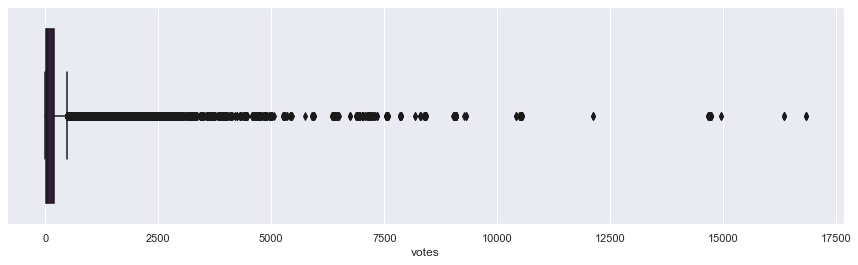

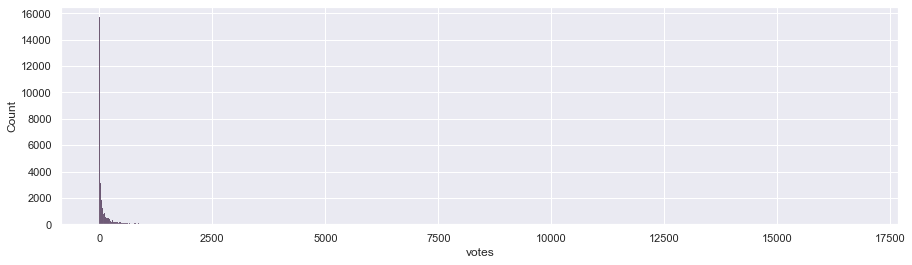

In [80]:
palette=sns.color_palette("rocket")
sns.set_palette(palette)

fig = plt.figure(figsize=[15,4])
sns.boxplot(x='votes', data=df)
plt.show()

fig = plt.figure(figsize=[15,4])
sns.histplot(x='votes', data=df)
plt.show()

In [81]:
df['votes_skewed']=np.where(df['votes']>0, np.log(df['votes']), 0)

C:\Users\Biswajit\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


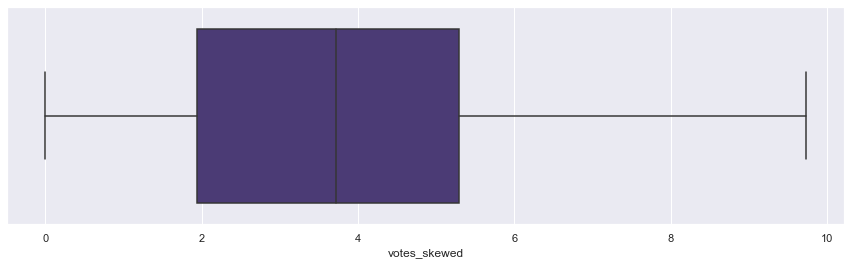

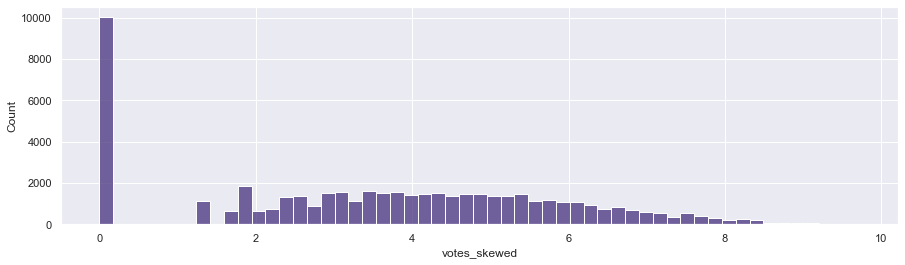

In [82]:
palette=sns.color_palette("viridis")
sns.set_palette(palette)

fig = plt.figure(figsize=[15,4])
sns.boxplot(x='votes_skewed', data=df)
plt.show()

fig = plt.figure(figsize=[15,4])
sns.histplot(x='votes_skewed', data=df)
plt.show()

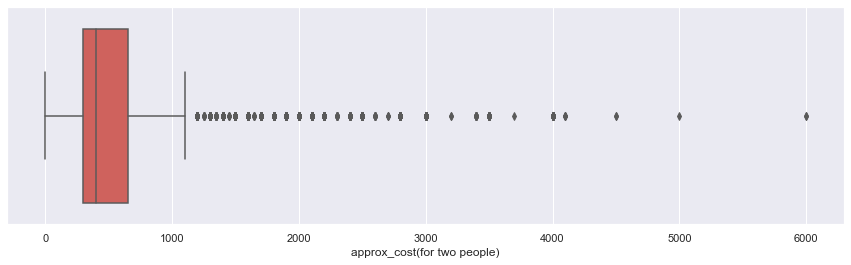

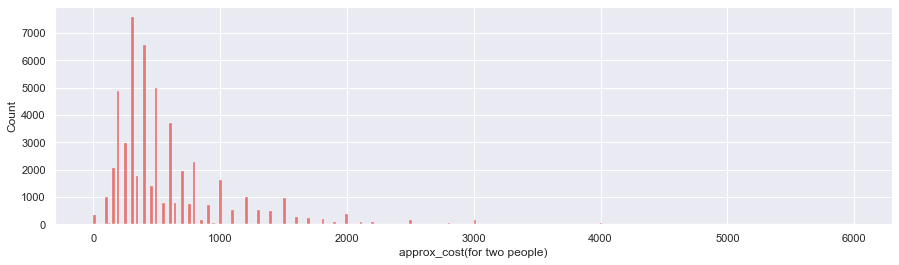

In [83]:
palette=sns.color_palette("Spectral")
sns.set_palette(palette)

fig = plt.figure(figsize=[15,4])
sns.boxplot(x='approx_cost(for two people)', data=df)
plt.show()

fig = plt.figure(figsize=[15,4])
sns.histplot(x='approx_cost(for two people)', data=df)
plt.show()

In [84]:
len(df[df['approx_cost(for two people)']==0])

346

In [85]:
print(df['approx_cost(for two people)'].mean(),df['approx_cost(for two people)'].median())

551.7155867509716 400.0


In [86]:
df['approx_cost_log']=np.where(df['approx_cost(for two people)']>0, np.log(df['approx_cost(for two people)']),0)

C:\Users\Biswajit\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


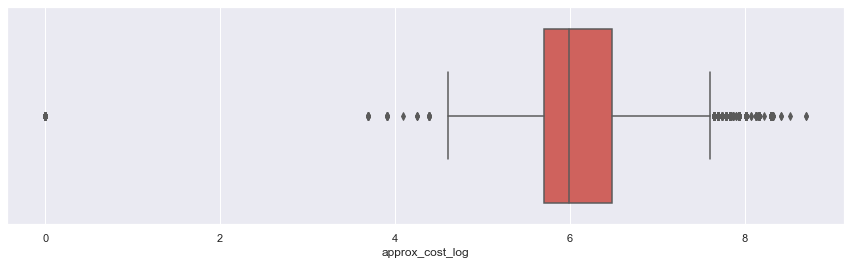

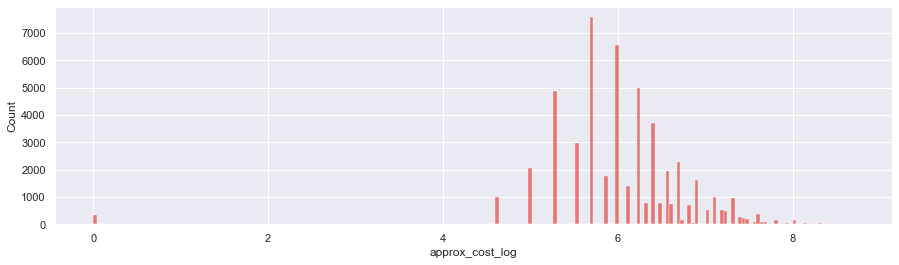

In [87]:
palette=sns.color_palette("Spectral")
sns.set_palette(palette)

fig = plt.figure(figsize=[15,4])
sns.boxplot(x='approx_cost_log', data=df)
plt.show()

fig = plt.figure(figsize=[15,4])
sns.histplot(x='approx_cost_log', data=df)
plt.show()

In [88]:
df=df.drop(['approx_cost(for two people)'],axis=1)

In [89]:
df.head(2)

,online_order,votes,reviews_list,listed_in(type),listed_in(city),ratings,Casual Dining,Cafe,Quick Bites,Delivery,Mess,Dessert Parlor,Bakery,Pub,Takeaway,Fine Dining,Beverage Shop,Sweet Shop,Bar,Confectionery,Kiosk,Food Truck,Microbrewery,Lounge,Food Court,Dhaba,Club,Irani Cafee,Bhojanalya,Pop Up,Meat Shop,North Indian,Mughlai,Chinese,Thai,Mexican,Italian,South Indian,Rajasthani,Andhra,Pizza,Continental,Momos,Beverages,Fast Food,American,French,European,Burger,Desserts,Biryani,Street Food,Rolls,Ice Cream,Healthy Food,Salad,Asian,Korean,Indonesian,Japanese,Goan,Seafood,Kebab,Steak,Mithai,Iranian,Sandwich,Juices,Mangalorean,Vietnamese,Hyderabadi,Bengali,Arabian,BBQ,Tea,Afghani,Lebanese,Finger Food,Tibetan,nan,Charcoal Chicken,Middle Eastern,Mediterranean,Wraps,Kerala,Oriya,Bihari,Roast Chicken,Maharashtrian,Bohri,African,Nepalese,Turkish,Tamil,Tex-Mex,Belgian,Gujarati,South American,Konkan,Drinks Only,Awadhi,Chettinad,Coffee,Indian,Afghan,Modern Indian,Lucknowi,Australian,Kashmiri,Spanish,Malaysian,Burmese,Sushi,Portuguese,Parsi,Greek,North Eastern,Bar Food,Singaporean,Naga,Cantonese,Grill,Bubble Tea,Hot dogs,Assamese,Sri Lankan,Mongolian,Paan,British,Pan Asian,German,Russian,Jewish,Vegan,Raw Meats,Malwani,Sindhi,location_encoded,menu_item_count,bk_encoded,votes_skewed,approx_cost_log
0,1,775,12,0,1,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,6.652863,6.684612
1,1,787,14,0,1,4.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6.668228,6.684612


In [90]:
df=df.drop(['votes'],axis=1)

In [93]:
df['reviews_list'].tolist()

[12,
 14,
 20,
 35,
 2,
 1,
 2,
 45,
 79,
 8,
 7,
 10,
 13,
 12,
 25,
 3,
 1,
 2,
 2,
 4,
 4,
 1,
 9,
 1,
 13,
 6,
 211,
 1,
 6,
 1,
 4,
 575,
 1,
 6,
 120,
 9,
 179,
 13,
 84,
 1,
 2,
 1,
 2,
 5,
 109,
 71,
 2,
 1,
 6,
 1,
 1,
 2,
 8,
 11,
 12,
 6,
 1,
 125,
 5,
 3,
 110,
 4,
 13,
 6,
 20,
 11,
 5,
 10,
 11,
 2,
 5,
 6,
 2,
 140,
 3,
 0,
 14,
 6,
 6,
 19,
 2,
 3,
 6,
 1,
 1,
 19,
 24,
 9,
 1,
 4,
 2,
 0,
 0,
 3,
 1,
 0,
 1,
 13,
 1,
 2,
 34,
 107,
 4,
 24,
 6,
 5,
 4,
 0,
 0,
 0,
 2,
 11,
 0,
 0,
 1,
 0,
 3,
 0,
 0,
 14,
 5,
 0,
 4,
 7,
 14,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 2,
 4,
 5,
 39,
 1,
 2,
 2,
 2,
 1,
 10,
 3,
 2,
 1,
 145,
 9,
 3,
 2,
 2,
 23,
 3,
 33,
 1,
 2,
 199,
 13,
 15,
 2,
 1,
 9,
 1,
 3,
 5,
 1,
 1,
 13,
 11,
 2,
 1,
 30,
 5,
 2,
 8,
 31,
 1,
 2,
 7,
 1,
 7,
 1,
 0,
 1,
 5,
 6,
 4,
 2,
 1,
 11,
 4,
 4,
 1,
 269,
 13,
 12,
 14,
 1,
 15,
 8,
 18,
 3,
 2,
 2,
 18,
 8,
 4,
 10,
 7,
 1,
 3,
 2,
 3,
 30,
 95,
 2,
 2,
 1,
 

In [95]:
df_corr_frame=pd.DataFrame({'reviews_count':df['reviews_list'].tolist(),'listed_in(type)':df['listed_in(type)'].tolist(),
                           'listed_in(city)':df['listed_in(city)'].tolist(),'approx_cost_log':df['approx_cost_log'].tolist(),
                           'votes_skewed':df['votes_skewed'].tolist(),'ratings':df['ratings'].tolist() })
df_corr_frame.head()

,reviews_count,listed_in(type),listed_in(city),approx_cost_log,votes_skewed,ratings
0,12,0,1,6.684612,6.652863,4.1
1,14,0,1,6.684612,6.668228,4.1
2,20,0,1,6.684612,6.822197,3.8
3,35,0,1,5.703782,4.477337,3.7
4,2,0,1,6.396930,5.111988,3.8


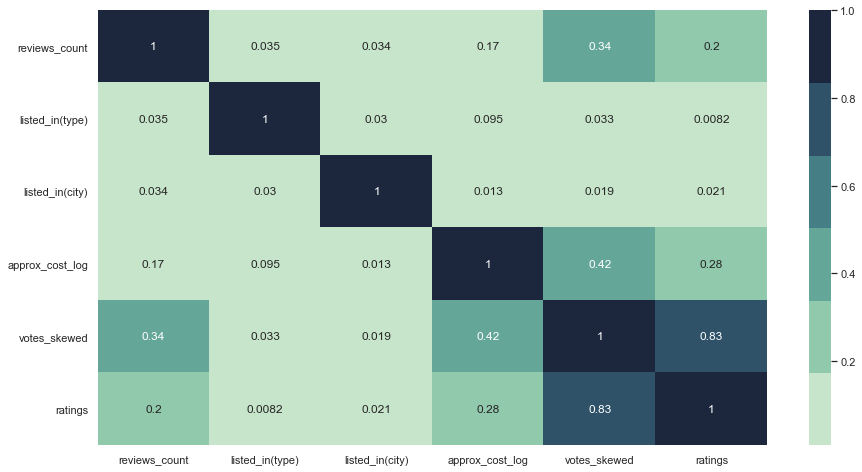

In [99]:
fig = plt.figure(figsize=[15,8])
    
sns.heatmap(df_corr_frame.corr(), annot=True, cmap=sns.cubehelix_palette(rot=-.4))

plt.show()

In [100]:
x=df.drop(['ratings'],axis=1)
y=df['ratings']

In [101]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [102]:
from sklearn.ensemble import RandomForestRegressor

In [103]:
regr = RandomForestRegressor(max_depth=5)

In [111]:
#applying kfold cross validation
scores = cross_val_score(regr, x, y,cv = 10)
scores

array([0.95836022, 0.9599555 , 0.96753433, 0.95877376, 0.90483377,
       0.96779538, 0.96767891, 0.96307348, 0.95543091, 0.96077469])

In [121]:
regr.fit(x_train, y_train)

RandomForestRegressor(max_depth=5)

In [122]:
y_pred=regr.predict(x_test)

In [123]:
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.9548434042273705
0.10313970714006285


In [114]:
x_test.head(20)

,online_order,reviews_list,listed_in(type),listed_in(city),Casual Dining,Cafe,Quick Bites,Delivery,Mess,Dessert Parlor,Bakery,Pub,Takeaway,Fine Dining,Beverage Shop,Sweet Shop,Bar,Confectionery,Kiosk,Food Truck,Microbrewery,Lounge,Food Court,Dhaba,Club,Irani Cafee,Bhojanalya,Pop Up,Meat Shop,North Indian,Mughlai,Chinese,Thai,Mexican,Italian,South Indian,Rajasthani,Andhra,Pizza,Continental,Momos,Beverages,Fast Food,American,French,European,Burger,Desserts,Biryani,Street Food,Rolls,Ice Cream,Healthy Food,Salad,Asian,Korean,Indonesian,Japanese,Goan,Seafood,Kebab,Steak,Mithai,Iranian,Sandwich,Juices,Mangalorean,Vietnamese,Hyderabadi,Bengali,Arabian,BBQ,Tea,Afghani,Lebanese,Finger Food,Tibetan,nan,Charcoal Chicken,Middle Eastern,Mediterranean,Wraps,Kerala,Oriya,Bihari,Roast Chicken,Maharashtrian,Bohri,African,Nepalese,Turkish,Tamil,Tex-Mex,Belgian,Gujarati,South American,Konkan,Drinks Only,Awadhi,Chettinad,Coffee,Indian,Afghan,Modern Indian,Lucknowi,Australian,Kashmiri,Spanish,Malaysian,Burmese,Sushi,Portuguese,Parsi,Greek,North Eastern,Bar Food,Singaporean,Naga,Cantonese,Grill,Bubble Tea,Hot dogs,Assamese,Sri Lankan,Mongolian,Paan,British,Pan Asian,German,Russian,Jewish,Vegan,Raw Meats,Malwani,Sindhi,location_encoded,menu_item_count,bk_encoded,votes_skewed,approx_cost_log
31615,0,0,4,17,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0.000000,4.605170
24264,1,4,2,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,6.502790,6.551080
12937,1,1,4,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,16,0,4.248495,5.991465
47125,0,12,4,26,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,0,0,3.258097,5.857933
35131,1,13,2,19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,47,56,0,6.423247,6.214608
37069,0,1,4,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,2.302585,5.298317
25729,0,1,2,15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,4.418841,6.214608
930,1,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,132,0,4.727388,5.991465
37031,0,1,4,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,3.663562,5

In [115]:
y_test.head(100)

31615    0.0
24264    4.0
12937    3.3
47125    2.8
35131    4.1
37069    3.6
25729    4.0
930      3.6
37031    3.1
29274    0.0
26388    0.0
27771    0.0
36633    3.9
21687    2.7
14311    3.9
6478     3.4
8834     3.1
50961    2.9
43137    3.0
5708     3.3
37217    3.4
28686    4.2
43070    4.5
20953    3.8
18687    4.2
9252     0.0
44272    3.3
31926    0.0
39486    4.1
21598    3.9
1417     3.7
39245    3.6
35627    0.0
17686    4.3
40472    3.9
23160    4.1
20921    0.0
9692     3.4
25075    2.8
19475    0.0
25286    3.9
45024    3.6
28577    3.8
43630    0.0
44738    0.0
49496    0.0
21748    3.4
21276    2.9
40513    4.3
29104    0.0
15008    3.2
17979    4.3
46156    3.0
22091    4.0
12331    4.4
4691     3.6
34907    3.5
15994    3.5
14407    0.0
28896    3.2
15081    4.3
32890    0.0
49839    4.2
50497    3.9
43500    3.4
26354    0.0
34236    3.8
37282    0.0
14088    3.1
9873     0.0
42967    3.6
47201    3.1
43363    4.3
18154    3.7
39249    3.6
40151    3.1
40754    3.0

In [133]:
sample=x_test.loc[50961].to_list()
regr.predict([sample])

array([3.59765858])

In [134]:
pickle.dump(regr, open('zomatoRatingPredict.pkl','wb'))